In [9]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams.sdeparams as sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

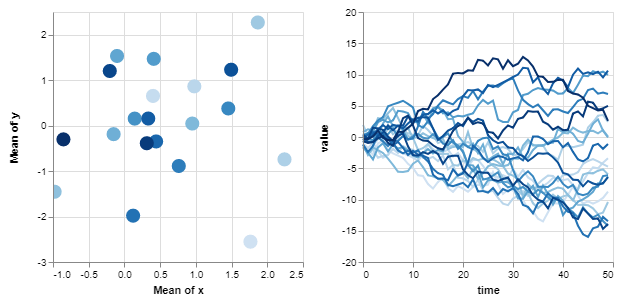

In [10]:
np.random.seed(0)

n_objects = 20
n_times = 50

# Create one (x, y) pair of metadata per object
locations = pd.DataFrame({
    'id': range(n_objects),
    'x': np.random.randn(n_objects),
    'y': np.random.randn(n_objects)
})

# Create a 50-element time-series for each object
timeseries = pd.DataFrame(np.random.randn(n_times, n_objects).cumsum(0),
                          columns=locations['id'],
                          index=pd.RangeIndex(0, n_times, name='time'))

# Melt the wide-form timeseries into a long-form view
timeseries = timeseries.reset_index().melt('time')

timeseries.id = timeseries.id.astype(int)

# Merge the (x, y) metadata into the long-form view
data = pd.merge(timeseries, locations, on='id')

# Data is prepared, now make a chart

selector = alt.selection_single(empty='all', fields=['id'])

points = alt.Chart(data).mark_point(filled=True, size=200).encode(
    x='mean(x)',
    y='mean(y)',
    color=alt.condition(selector, 'id:O', alt.value('lightgray'), legend=None),
).properties(
    selection=selector,
    width=250, height=250
).interactive()

timeseries = alt.Chart(data).mark_line().encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
).properties(
    selection=selector,
    width=250, height=250
)

points | timeseries

In [11]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
id    20 non-null int64
x     20 non-null float64
y     20 non-null float64
dtypes: float64(2), int64(1)
memory usage: 560.0 bytes


In [12]:
ndim = 3
N = 1714

def A(x, *params):
    s0, beta, w, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([-beta*s*i/N, beta*s*i/N - w*e, w*e - gamma*i])

def B(x, *params):
    s0, beta, w, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([[beta*s*i/N, -beta*s*i/N, 0.], [-beta*s*i/N, beta*s*i/N + w*e, -w*e], [0., -w*e, w*e + gamma*i]])

def Jac(x, *params):
    s0, beta, w, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([[-beta*i/N, 0., -beta*s/N], [beta*i/N, -w, beta*s/N], [0., w, -gamma]])

In [13]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    x_t = []
    
    x_0 = x.copy()
    for time in t:
        x_t.append(x_0.copy())
        y = A(x_0, *params)*dt + np.sqrt(dt)*np.random.multivariate_normal(np.zeros(ndim), B(x_0, *params))
        x_0 += np.maximum(y, -np.array(x_0))
            
    return np.array(x_t)

In [14]:
data = pd.read_csv('data_norovirus.csv', index_col='day')

In [15]:
def LNA(x, t, *params):
    y = np.maximum(x[:ndim], np.zeros(ndim))
    x_det = A(y, *params)
    Xi = np.reshape(x[ndim:], (ndim,ndim))
    J = Jac(y, *params)
    dXidt = np.dot(J, Xi) + np.dot(Xi, J.transpose()) + B(y, *params)

    return np.concatenate((x_det, dXidt.flatten()))

In [16]:
n_obs = 1

def costfn(params, *measurements):
    data, times = measurements
    
    s0 = params[0]
    
    data = s0 - data
    now = np.append(data[0], np.array([0,1]))
    
    total = 0.
    for i in range(len(data)-1):
        estimation = sdeparams.likelihood_next(params, LNA, now, data[i+1], times[i], times[i+1], n_obs=n_obs, estimate_N=False, N=1)
        total -= np.log(estimation[0])
        
        now = np.append(data[i+1], estimation[1])
        
    return total

In [17]:
def reconstruct(params, measurements):

    data, times = measurements

    s0 = params[0]
    
    data = s0 - data
    now = np.append(data[0], np.array([0,1]))
    
    x_t = [now]
    for i in range(len(data)-1):
        next_point = sdeparams.draw_next(params, LNA, now, data[i+1], times[i], times[i+1], n_obs=n_obs, estimate_N=False, N=1)
        
        next_point = np.maximum(next_point, np.zeros(ndim))
        
        x_t.append(next_point)
        
        if ndim > n_obs:
            now = np.append(data[i+1], next_point[n_obs:])
        else:
            now = data[i+1]
    return np.array(x_t)

In [18]:
observations = (data.cumulative.values, data.index.values)

In [9]:
bounds = [(250, 250), (0., 30.), (2., 2.), (0., 10.)]

estimation = differential_evolution(costfn, bounds, args=observations)

In [19]:
#params_estim = tuple(estimation.x)

params_estim = (250.0, 21.074556601678506, 2.0, 1.4860320053882778)

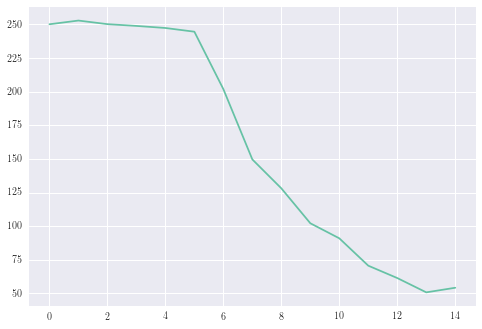

In [20]:
plt.plot(observations[1], reconstruct(params_estim, observations)[:,0])

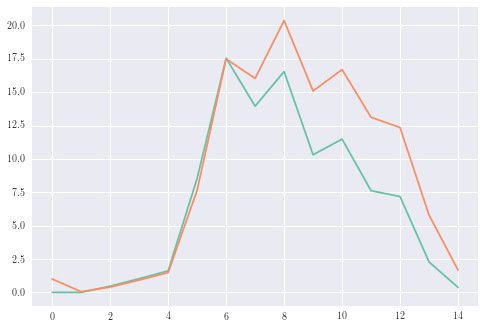

In [12]:
plt.plot(observations[1], reconstruct(params_estim, observations)[:,1:])

In [21]:
betas = np.linspace(params_estim[1]-5,params_estim[1]+5,10)
gammas = np.linspace(params_estim[3]-0.5,params_estim[3]+0.5,10)

likelihood = []
for b in betas:
    for g in gammas:
        likelihood.append([b, g, np.exp(-costfn((250,b,2,g), *observations)/costfn(params_estim, *observations))])
likelihood=np.array(likelihood)

In [22]:
locations = pd.DataFrame(likelihood, columns=['beta', 'gamma', 'likelihood'])

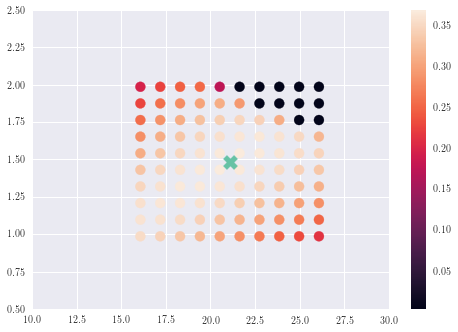

In [26]:
f, ax = plt.subplots()
points = ax.scatter(locations.beta, locations.gamma, c=locations.likelihood, s=100)
ax.scatter([params_estim[1]],[params_estim[3]], marker='X', s=200)
ax.set_xlim(10,30)
ax.set_ylim(0.5,2.5)
f.colorbar(points)

In [52]:
locations['id'] = locations.index.values.astype(int)

In [61]:
locations.head()

,beta,gamma,likelihood,id
0,16.074557,0.986032,0.352820,0
1,16.074557,1.097143,0.359966,1
2,16.074557,1.208254,0.357261,2
3,16.074557,1.319365,0.346629,3
4,16.074557,1.430476,0.329796,4


In [62]:
t = np.linspace(0., 14., 1000)
x0 = [params_estim[0], 0, 1]

s_m = pd.DataFrame({'t': t})
s_u = pd.DataFrame({'t': t})
s_d = pd.DataFrame({'t': t})

e_m = pd.DataFrame({'t': t})
e_u = pd.DataFrame({'t': t})
e_d = pd.DataFrame({'t': t})

i_m = pd.DataFrame({'t': t})
i_u = pd.DataFrame({'t': t})
i_d = pd.DataFrame({'t': t})

for i, x in locations.iterrows():
    
    params = (250, x.beta, 2, x.gamma)
    
    results_s = pd.DataFrame({'t': t})
    results_e = pd.DataFrame({'t': t})
    results_i = pd.DataFrame({'t': t})

    for i in range(10):
        result = path(x0, t, *params_estim)
        results_s['x'+str(i)] = result[:,0]
        results_e['x'+str(i)] = result[:,1]
        results_i['x'+str(i)] = result[:,2]
    
    mean_s = results_s[results_s.columns[1:]].mean(axis=1)
    s_m[str(x.id)] = mean_s
    s_u[str(x.id)] = mean_s+results_s[results_s.columns[1:]].std(axis=1)
    s_d[str(x.id)] = mean_s-results_s[results_s.columns[1:]].std(axis=1)
    
    mean_e = results_e[results_e.columns[1:]].mean(axis=1)
    e_m[str(x.id)] = mean_e
    e_u[str(x.id)] = mean_e+results_e[results_e.columns[1:]].std(axis=1)
    e_d[str(x.id)] = mean_e-results_e[results_e.columns[1:]].std(axis=1)
    
    mean_i = results_i[results_i.columns[1:]].mean(axis=1)
    i_m[str(x.id)] = mean_i
    i_u[str(x.id)] = mean_i+results_i[results_i.columns[1:]].std(axis=1)
    i_d[str(x.id)] = mean_i-results_i[results_i.columns[1:]].std(axis=1)
    
i_m = i_m.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'I'})
i_m.id = i_m.id.astype(float).astype(int)
i_u = i_u.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'I'})
i_u.id = i_u.id.astype(float).astype(int)
i_d = i_d.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'I'})
i_d.id = i_d.id.astype(float).astype(int)

e_m = e_m.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'E'})
e_m.id = e_m.id.astype(float).astype(int)
e_u = e_u.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'E'})
e_u.id = e_u.id.astype(float).astype(int)
e_d = e_d.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'E'})
e_d.id = e_d.id.astype(float).astype(int)

s_m = s_m.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'S'})
s_m.id = s_m.id.astype(float).astype(int)
s_u = s_u.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'S'})
s_u.id = s_u.id.astype(float).astype(int)
s_d = s_d.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'S'})
s_d.id = s_d.id.astype(float).astype(int)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [78]:
inf_m = pd.merge(i_m, locations, on='id')
inf_u = pd.merge(i_u, locations, on='id')
inf_d = pd.merge(i_d, locations, on='id')

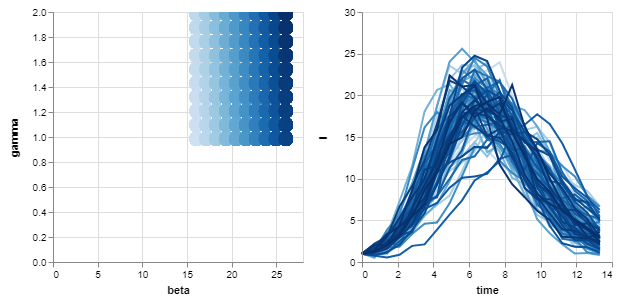

In [85]:
selector = alt.selection_single(empty='all', fields=['id'])

points = alt.Chart(inf_m.iloc[::50]).mark_point(filled=True, size=200).encode(
    x='beta',
    y='gamma',
    color=alt.condition(selector, 'id:O', alt.value('lightgray'), legend=None),
).properties(
    selection=selector,
    width=250, height=250
).interactive()

timeseries = alt.Chart(inf_m.iloc[::50]).mark_line().encode(
    x='time',
    y=alt.Y('I', scale=alt.Scale(domain=(0, 30))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
).properties(
    selection=selector,
    width=250, height=250
)

points | timeseries

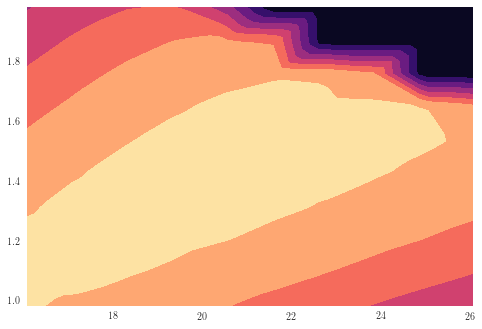

In [95]:
from matplotlib.mlab import griddata

fig, axes = plt.subplots()

X, Y, Z = locations.beta.values, locations.gamma.values, locations.likelihood.values

times = np.linspace(min(X), max(X))
effs = np.linspace(min(Y), max(Y))

aspect = (times[-1]-times[0])/(effs[-1]-effs[0])


AUCs = griddata(X, Y, Z, times, effs, interp='linear')
im = axes.contourf(times, effs, AUCs, cmap='magma')#, levels=np.linspace(0., 1., 25))

In [75]:
inf_m.iloc[::50]

,time,id,I,beta,gamma,likelihood
0,0.000000,0,1.000000,16.074557,0.986032,0.352820
50,0.700701,0,0.965509,16.074557,0.986032,0.352820
100,1.401401,0,1.100653,16.074557,0.986032,0.352820
150,2.102102,0,2.054004,16.074557,0.986032,0.352820
200,2.802803,0,3.744395,16.074557,0.986032,0.352820
250,3.503504,0,6.071002,16.074557,0.986032,0.352820
300,4.204204,0,8.243172,16.074557,0.986032,0.352820
350,4.904905,0,11.875417,16.074557,0.986032,0.352820
400,5.605606,0,13.833740,16.074557,0.986032,0.352820
450,6.306306,0,16.164904,16.074557,0.986032,0.352820


In [14]:
mean_s = results_s[results_s.columns[1:]].mean(axis=1)
plus_s = mean_s+results_s[results_s.columns[1:]].std(axis=1)
minus_s = mean_s-results_s[results_s.columns[1:]].std(axis=1)

mean_e = results_e[results_s.columns[1:]].mean(axis=1)
plus_e = mean_e+results_e[results_s.columns[1:]].std(axis=1)
minus_e = mean_e-results_e[results_s.columns[1:]].std(axis=1)

mean_i = results_i[results_s.columns[1:]].mean(axis=1)
plus_i = mean_i+results_i[results_s.columns[1:]].std(axis=1)
minus_i = mean_i-results_i[results_s.columns[1:]].std(axis=1)

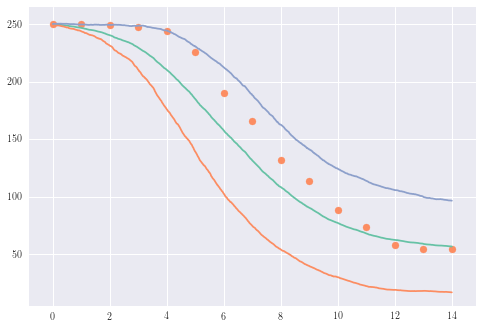

In [15]:
plt.plot(t, mean_s)
plt.plot(t, minus_s)
plt.plot(t, plus_s)
plt.scatter(observations[1], params_estim[0]-observations[0],c=colours[1])

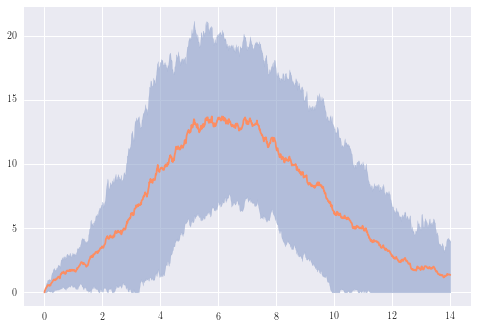

In [16]:
plt.plot(t, mean_e, c=colours[1])
#plt.plot(t, np.maximum(minus_e,np.zeros_like(minus_e)), c=colours[2])
#plt.plot(t, plus_e, c=colours[2])
plt.fill_between(t, plus_e, np.maximum(minus_e,np.zeros_like(minus_e)), color=colours[2], alpha=0.6)
#plt.scatter(observations[1], params_estim[0]-observations[0],c=colours[1])

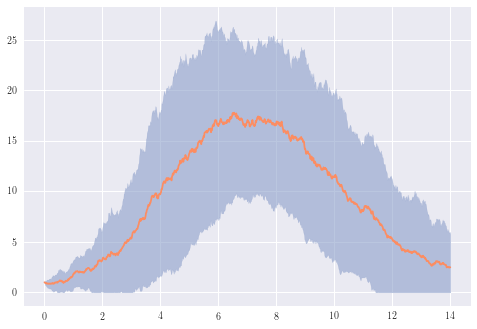

In [17]:
plt.plot(t, mean_i, c=colours[1])
#plt.plot(t, np.maximum(minus_i,np.zeros_like(minus_i)), c=colours[2])
#plt.plot(t, plus_i, c=colours[2])
plt.fill_between(t, plus_i, np.maximum(minus_i,np.zeros_like(minus_i)), color=colours[2], alpha=0.6)
#plt.scatter(observations[1], params_estim[0]-observations[0],c=colours[1])

In [33]:
locations2 = pd.DataFrame({
    'id': range(n_objects),
    'x': np.random.randn(n_objects),
    'y': np.random.randn(n_objects)
})

timeseries = pd.DataFrame(np.random.randn(n_times, n_objects).cumsum(0),
                          columns=locations2['id'],
                          index=pd.RangeIndex(0, n_times, name='time'))

In [34]:
timeseries

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
time,,,,,,,,,,,,,,,,,,,,
0,1.080544,-1.607677,0.456164,-0.944870,0.570789,1.542796,-0.000417,0.374155,0.409552,-0.799593,1.511639,1.706468,0.701783,0.073285,-0.461894,-0.626490,1.710837,1.414415,-0.063661,-1.579931
1,-1.751468,-2.691103,0.325543,0.455819,-0.080868,2.047612,1.302764,0.502691,0.267104,-2.108357,0.309164,2.122568,0.500876,0.195817,-0.509172,0.037654,0.926149,1.078834,1.832521,-2.379717
2,-2.033043,-3.280490,0.770325,1.478211,-0.579079,1.616197,1.023782,1.032525,-0.472291,-2.484317,-2.063030,0.740823,0.388432,1.093681,-0.214096,-1.061115,-0.474107,1.253514,0.179717,-1.313790
3,-1.969147,-4.887810,-0.195629,0.753900,-1.352272,0.126264,0.149120,0.348124,-1.183577,-1.356360,-1.958202,-0.252434,0.053810,0.214124,-0.514102,-0.185605,-0.221836,3.539116,0.555645,-2.227384
4,-1.159406,-3.807879,0.898538,-0.340341,-1.499909,1.258076,-1.535609,-0.151293,-2.610515,-2.288931,-2.970659,0.998135,-0.180728,-0.649232,-1.549708,-0.043938,-0.232972,4.883190,1.055661,-3.659182
5,-1.788387,-2.737806,0.277455,1.394231,-2.598199,1.830690,-2.396825,-0.660888,-1.511933,-2.415998,-2.157207,1.471426,0.573138,-1.537420,-1.771283,0.380314,-1.082045,6.512690,0.278433,-3.959186
6,-2.794946,-4.881114,2.074374,1.189892,-3.046113,1.631975,-0.976961,-1.625995,-0.832365,-2.839786,-2.753878,2.038484,1.561379,-2.051323,-2.540132,-0.788781,0.021459,5.937434,-1.570698,-2.549234
7,-4.164806,-4.101654,2.257802,1.477808,-3.630489,1.997566,-2.644741,-1.037957,0.724645,-1.955759,-4.773418,1.054275,1.373584,-1.564386,-2.646784,-1.281996,0.616759,7.101586,-1.802992,-1.820304
8,-6.743856,-5.039163,1.936543,0.989241,-3.297691,3.011317,-2.138072,-1.660183,-0.798123,-1.398795,-6.611595,1.707313,1.185135,-2.740221,-2.359527,-1.284872,0.580162,7.017363,-1.383467,-0.895870
